In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/zvuk-dataset/zvuk-interactions.parquet
/kaggle/input/zvuk-dataset/zvuk-track_artist_embedding.parquet


In [2]:
df = pd.read_parquet('/kaggle/input/zvuk-dataset/zvuk-interactions.parquet')

Шаг 0: Определение пользователей для выборки...
Шаг 0: Загрузка данных для 3827 выбранных пользователей...
Данные успешно загружены. Размер итогового DataFrame: 2429878 строк.
Шаг 1: Сжатие типов и создание признаков...
Шаг 2.1: Расчет времени на сессию...
Mean Time per Session: 1745.47
Шаг 2.2: Расчет пользовательских метрик...

User Stats Summary:
         total_time    skip_rate
count  3.827000e+03  3827.000000
mean   6.422344e+04     0.428437
std    1.631645e+05     0.255242
min   -7.970500e+04     0.000000
25%    1.662000e+03     0.225170
50%    1.175700e+04     0.400000
75%    5.867000e+04     0.599108
max    4.993442e+06     1.000000
Шаг 2.3: Анализ почасовой динамики...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


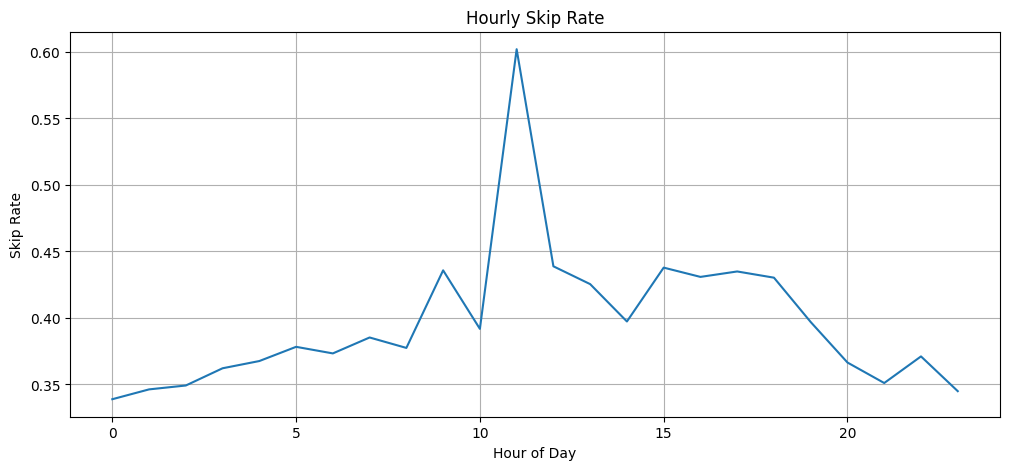

Шаг 3: Оценка CUPED...

CUPED Correlation (Total Time): 0.7895
CUPED Correlation (Skip Rate): 0.4935


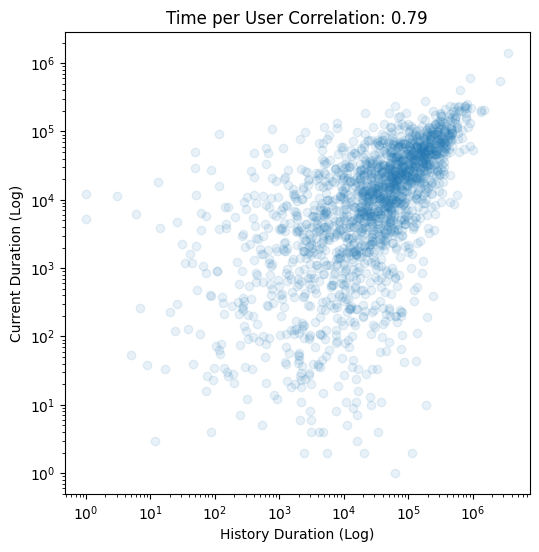

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc


SAMPLE_FRACTION = 0.01

print("Шаг 0: Определение пользователей для выборки...")
all_user_ids = pd.read_parquet('/kaggle/input/zvuk-dataset/zvuk-interactions.parquet', columns=['user_id'])
unique_user_ids = all_user_ids['user_id'].unique()

sample_user_ids = np.random.choice(unique_user_ids, size=int(len(unique_user_ids) * SAMPLE_FRACTION), replace=False)

del all_user_ids, unique_user_ids
gc.collect()

print(f"Шаг 0: Загрузка данных для {len(sample_user_ids)} выбранных пользователей...")
df = pd.read_parquet(
    '/kaggle/input/zvuk-dataset/zvuk-interactions.parquet',
    columns=['user_id', 'session_id', 'datetime', 'track_id', 'play_duration'],
    filters=[('user_id', 'in', sample_user_ids.tolist())]
)

print(f"Данные успешно загружены. Размер итогового DataFrame: {df.shape[0]} строк.")
gc.collect()


# --- Шаг 1: Сжатие типов и создание признаков ---
print("Шаг 1: Сжатие типов и создание признаков...")
df['user_id'] = df['user_id'].astype(np.int32)
df['session_id'] = df['session_id'].astype(np.int32)
df['track_id'] = df['track_id'].astype(np.int32)
df['play_duration'] = df['play_duration'].astype(np.float32)
df['datetime'] = pd.to_datetime(df['datetime'])

# --- Шаг 2: Расчет метрик с минимальным созданием объектов ---
# Метрика "Время на сессию": разделяем сессии, которые пересекают полночь.
# Если дата меняется внутри одной сессии, создается новый ID.
print("Шаг 2.1: Расчет времени на сессию...")
session_date_diff = df.groupby('session_id')['datetime'].transform(lambda x: x.dt.date.diff().ne(pd.Timedelta(0)))
df['session_id'] = session_date_diff.cumsum().astype(np.int32)
del session_date_diff
gc.collect()

session_stats = df.groupby('session_id')['play_duration'].sum()
print(f"Mean Time per Session: {session_stats.mean():.2f}")
del session_stats
gc.collect()

# Метрика "Доля непрослушанных треков": определяем "скип" по динамическому порогу.
# Порог - 30 секунд, но не более реальной длины трека (оцененной по max()).
print("Шаг 2.2: Расчет пользовательских метрик...")
df['estimated_track_len'] = df.groupby('track_id')['play_duration'].transform('max').astype(np.float32)
df['is_skipped'] = (df['play_duration'] < (np.minimum(30, df['estimated_track_len']) - 1.0)).astype(np.uint8)
del df['estimated_track_len']
gc.collect()
# Агрегируем данные по пользователям для расчета их общего времени и средней доли скипов.
user_stats = df.groupby('user_id').agg(total_time=('play_duration', 'sum'), skip_rate=('is_skipped', 'mean'))
print("\nUser Stats Summary:")
print(user_stats.describe())
del user_stats
gc.collect()
# Анализ влияния часа на скипы: группируем по часу и считаем средний skip_rate.
print("Шаг 2.3: Анализ почасовой динамики...")
df['hour'] = df['datetime'].dt.hour.astype(np.int8)
hourly_stats = df.groupby('hour')['is_skipped'].mean()

plt.figure(figsize=(12, 5))
sns.lineplot(x=hourly_stats.index, y=hourly_stats.values)
plt.title('Hourly Skip Rate')
plt.xlabel('Hour of Day')
plt.ylabel('Skip Rate')
plt.grid(True)
plt.show()
del df['hour'], hourly_stats
gc.collect()

# --- Шаг 3: Оценка CUPED ---
# Для анализа CUPED делим данные на 2 периода (75% "история" и 25% "текущий").
print("Шаг 3: Оценка CUPED...")
split_time = df['datetime'].quantile(0.75)
df['period'] = np.where(df['datetime'] < split_time, 0, 1).astype(np.int8)
# Группируем по пользователю и периоду, затем unstack() превращает данные в "широкий" формат (1 строка = 1 юзер).
cuped_df = df.groupby(['user_id', 'period']).agg(
    total_time=('play_duration', 'sum'),
    skip_rate=('is_skipped', 'mean')
).unstack(level='period')
cuped_df.dropna(inplace=True)
# Считаем корреляцию между метриками "до" и "после" для оценки стабильности поведения.
time_corr = cuped_df['total_time'][0].corr(cuped_df['total_time'][1])
skip_corr = cuped_df['skip_rate'][0].corr(cuped_df['skip_rate'][1])

print(f"\nCUPED Correlation (Total Time): {time_corr:.4f}")
print(f"CUPED Correlation (Skip Rate): {skip_corr:.4f}")

plt.figure(figsize=(6, 6))
plt.scatter(cuped_df['total_time'][0], cuped_df['total_time'][1], alpha=0.1)
plt.xscale('log')
plt.yscale('log')
plt.title(f'Time per User Correlation: {time_corr:.2f}')
plt.xlabel('History Duration (Log)')
plt.ylabel('Current Duration (Log)')
plt.show()

**Среднее время прослушивания** за одну сессию составляет 1745 секунд (около 29 минут). Это высокий показатель, говорящий о том, что пользователи, начиная слушать музыку, остаются в сервисе надолго.

**Средняя доля пропущенных треков** (skip rate) на пользователя составляет 42.8%. Это означает, что в среднем почти каждый второй трек пропускается. Пользователи не слушают музыку пассивно, а активно ищут то, что им нравится.

**Медианное время** (50%) на пользователя — 11,757 секунд.

**Среднее время** (mean) — 64,223 секунды.
Такая большая разница говорит о том, что небольшая группа очень активных пользователей слушает музыку на порядки больше, чем большинство, и "тянет" среднее значение вверх. При анализе важно сегментировать пользователей по активности.

**Ночное прослушивание** (00:00 - 05:00): В это время наблюдается самый низкий skip rate (0.34-0.36). Это соответствует сценариям фонового прослушивания: музыка для сна, отдыха, когда пользователи не взаимодействуют активно с приложением.

**Утренний и дневной рост** (06:00 - 10:00): Доля скипов плавно растет, что совпадает с началом дня, поездками на работу/учебу. Пользователи активно ищут плейлисты и треки для создания настроения.

**Аномальный пик в 11:00**: Обнаружен резкий и очень высокий скачок skip rate до 0.6, который сильно выбивается из общего тренда.

**Вечерний "прайм-тайм"** (14:00 - 22:00): Доля скипов остается стабильно высокой (0.40-0.44), постепенно снижаясь к ночи. Это основное время активного потребления контента.

Перспективы использования **CUPED**

**Корреляция общего времени прослушивания** составила 0.79. Пользователи, которые много слушали музыку в прошлом, с большой вероятностью продолжат много слушать ее и в будущем

**Корреляция skip rate** составила 0.49. Привычка пользователя часто или редко пропускать треки также сохраняется со временем